In [3]:
using Revise, NeuralNetworkAnalysis, JLD2, Plots
const NNA = NeuralNetworkAnalysis

using NeuralNetworkAnalysis: _forward_network

In [37]:
@load "/home/sguadalupe/.julia/dev/NeuralNetworkAnalysis/models/ACC/acc3.jld2" controller

1-element Array{Symbol,1}:
 :controller

In [49]:
controller.layers[4].weights

1×20 Array{Float64,2}:
 0.563364  0.0207789  -0.00882743  …  -0.00452622  0.00655114  -0.0147388

In [138]:
@taylorize function ACC!(dx, x, p, t)
    local a_lead, u = -100., 0.0001
    x_lead, v_lead, γ_lead, x_ego, v_ego, γ_ego, a_ego = x

    dx[1] = v_lead
    dx[2] = γ_lead
    dx[3] = 2 * (a_lead - γ_lead) - u * v_lead^2
    dx[4] = v_ego
    dx[5] = γ_ego
    dx[6] = 2 * (a_ego - γ_ego) - u * v_ego^2
    dx[7] = zero(a_ego)
end

In [66]:
X₀ = Hyperrectangle(low=[90., 32, 0, 10, 30, 0], high=[110, 32.2, 0, 11, 30.2, 0])
W₀ = Hyperrectangle(low=[30., 1.4, 30., 80., 2.], high=[30., 1.4, 30.2, 99., 2.])
U₀ = _forward_network(solver, controller, W₀)

Zonotope{Float64,Array{Float64,1},Array{Float64,2}}([-0.07012024020117164], [-0.038222979527168605 0.035003381119895975 -0.010008594957471152])

In [98]:
overapproximate(U₀, Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-0.07012024020117164], [0.08323495560453574])

In [142]:
prob = @ivp(x' = ACC!(x), dim: 7, x(0) ∈ X₀ × overapproximate(U₀, Hyperrectangle)*0);

In [143]:
alg = TMJets(abs_tol=1e-9, orderT=8, orderQ=2)

@time sol = solve(prob, T=1.4, alg=alg)
solz = overapproximate(sol, Zonotope);

  0.322729 seconds (4.70 M allocations: 487.857 MiB, 29.53% gc time)


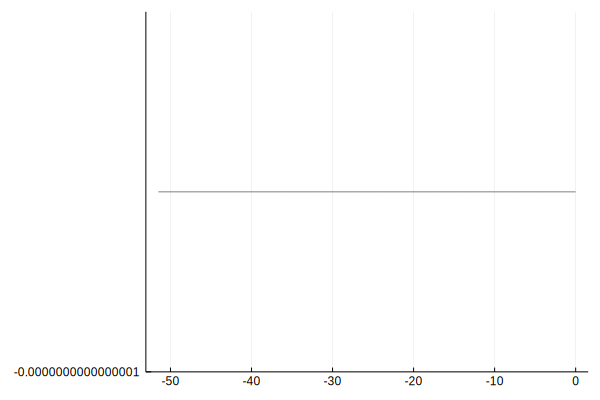

In [144]:
plot(solz, vars=(1, 4))